In [35]:
%run srcnn.py
%matplotlib inline

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from keras.callbacks import ModelCheckpoint
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7147568065078815706
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8611194471
locality {
  bus_id: 2
}
incarnation: 18309087023422187370
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


### Load images

In [4]:
PATH = "datasets"
TRAIN_FILE = PATH + "/DIV2K_train_HR/"

In [5]:
obj_files = listdir(TRAIN_FILE )
imgs = []

for i in range(0,90):
    n = obj_files[i]
    img = Image.open(TRAIN_FILE + n)
    img = to_ycbcr(img)
    imgs.append(np.asarray(img))

(2040, 1356)


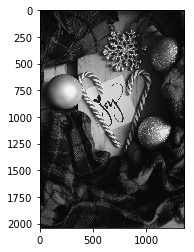

In [6]:
print(imgs[0].shape)

plt.imshow(imgs[0], 'gray')

### Generate train and test set
In the training phase, the ground truth images {Xi } are prepared as 32 × 32-
sub-images. To synthesize the low-resolution samples {Yi}, we blur a sub-image by a proper Gaussian kernel, sub-sample it by the upscaling factor, and upscale it by the same factor via bicubic interpolation. 
The sub-images are extracted from original images with a stride of 14.

#### Original image and bicubic interpolated image

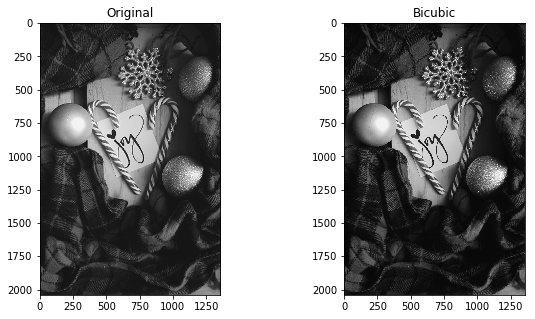

In [7]:
sample, label = get_input_images(imgs[0],  scale = 4. )
plot_images([sample, label], ["Bicubic", "Original"], ch=1)

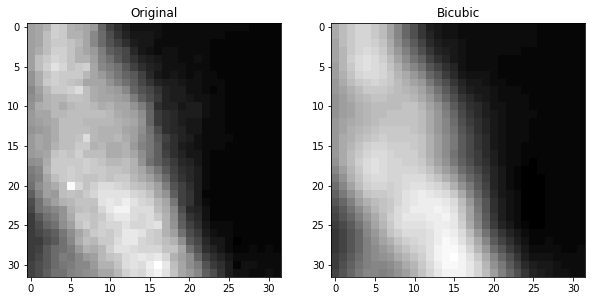

In [8]:
smp, ptch = generate_patches(imgs[0])

img_size = utility.getSize(smp[0])[0]
plot_images([smp[11], ptch[11]], ["Bicubic", "Original"], ch=1)

#### Example of our train and test set images

(32, 32)


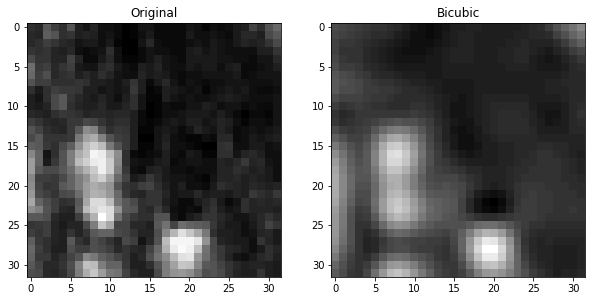

In [9]:
samples_list, labels_list = image_patches(imgs,  scale = 4.)

print(labels_list[500].shape)
plot_images([samples_list[500], labels_list[500]], ["Bicubic", "Original"], ch=1)

In [10]:
index = [i for i in range(len(samples_list))]
random.shuffle(index)

samples = np.asarray(samples_list)
labels = np.asarray(labels_list)

samples = samples
labels = labels


In [11]:
train, test = normalize(samples, labels)
train, test = reshape(train, test, ch=1)

### Convolutional Neural Networks

In [12]:
model = srcnn_mode()
srcnn_compile(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
__________

In [14]:
batch_size = 64
epochs = 50


filepath="checkpoints/weights.spatial.best" +  "-{epoch:02d}-{val_loss:.4f}" + ".hdf5"

model.load_weights("checkpoints/weights.spatial.best-40-0.0041.hdf5")

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=5)
callbacks_list = [checkpoint]

model.fit(train, test,
          epochs=epochs,
          verbose=1,
          batch_size=batch_size,
          validation_split = 0.2,
          callbacks=callbacks_list)

Train on 996940 samples, validate on 249236 samples
Epoch 1/10
996940/996940 [==============================] - 1224s 1ms/step - loss: 0.0031 - psnr: 58.0655 - val_loss: 0.0041 - val_psnr: 66.4208
Epoch 2/10
996940/996940 [==============================] - 1483s 1ms/step - loss: 0.0031 - psnr: 58.0746 - val_loss: 0.0041 - val_psnr: 66.8262
Epoch 3/10
996940/996940 [==============================] - 1512s 2ms/step - loss: 0.0031 - psnr: 58.0795 - val_loss: 0.0041 - val_psnr: 65.2845
Epoch 4/10
996940/996940 [==============================] - 1520s 2ms/step - loss: 0.0031 - psnr: 58.0881 - val_loss: 0.0041 - val_psnr: 66.6750
Epoch 5/10
996940/996940 [==============================] - 1535s 2ms/step - loss: 0.0031 - psnr: 58.0976 - val_loss: 0.0041 - val_psnr: 66.5094

Epoch 00005: val_loss improved from inf to 0.00409, saving model to checkpoints/weights.spatial.best-05-0.0041.hdf5
Epoch 6/10
996940/996940 [==============================] - 1531s 2ms/step - loss: 0.0031 - psnr: 58.1019 

In [15]:
name = "sptial_deep_model_50_ycbcr"
save_model(model, name)

In [16]:
TEST_FILE5 = "datasets/SR_Test/Set5/"
def get_test_dataset(test_name = TEST_FILE5) :
    vald_pil = load_images([TEST_FILE5 ], channels=1)
    return vald_pil


(256, 256)


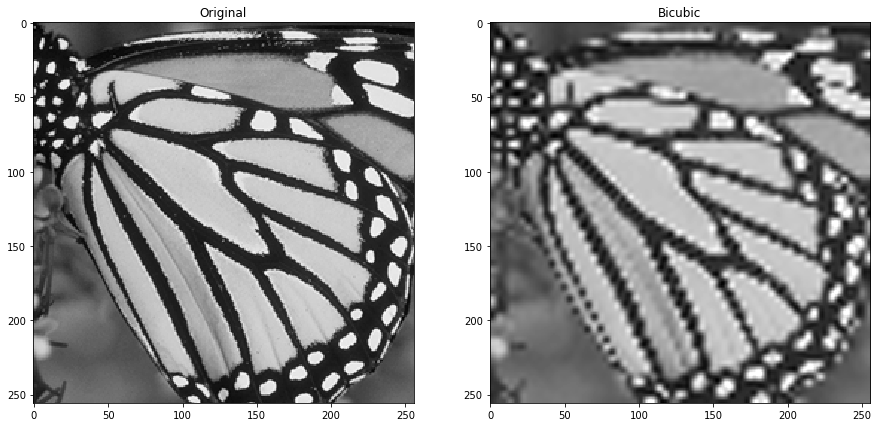

In [41]:
index=3
vald_pil = get_test_dataset()
val_img = vald_pil[index]

org, bicubic = get_input_images(val_img, 4.)

print(bicubic.shape)
plot_images([bicubic, org], ["Bicubic", "Original"], size=(15,10), ch=1)

In [42]:
val_img.shape

(256, 256)

In [43]:
#plt.imshow(im[0])

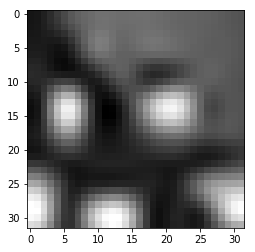

In [44]:
subBic, subOrg = generate_patches(val_img, 
                                  patch_size = 32, 
                                  label_size = 32, 
                                  scale = 4., 
                                  stride = 30 )
    
    
subBic = np.asarray(subBic)
subOrg = np.asarray(subOrg)


subOrg, subBic = normalize(subOrg, subBic)
subOrg, subBic = reshape(subOrg, subBic, ch=1)

plt.imshow(subBic[0][:,:, 0], 'gray')

In [47]:
pred = model.predict(subBic)
pred = pred.clip(0,1)
pred.shape

(64, 32, 32, 1)

In [48]:
h, w = utility.getSize(val_img)
image = patch_to_image(pred, h, w, 0, 32, 32, stride=30)

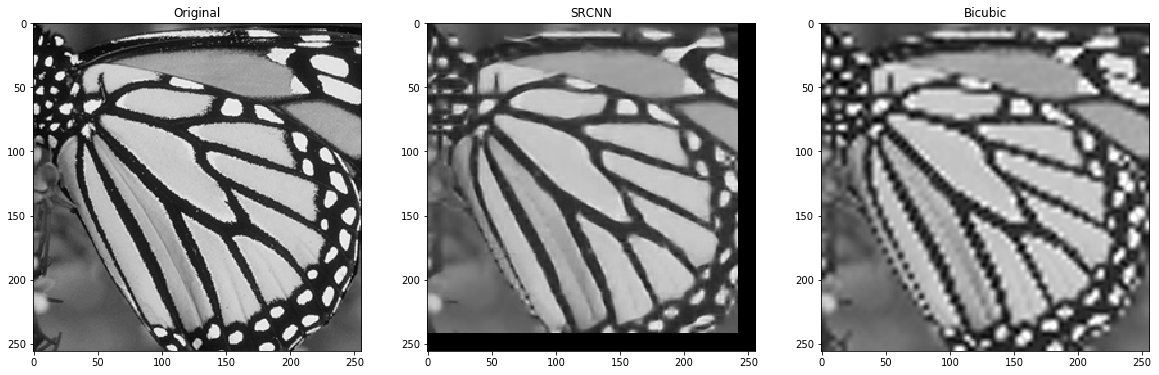

In [49]:
plot_images([bicubic, val_img, image], ["Bicubic", "Original", "SRCNN"], size=(20, 10))

### test.shape

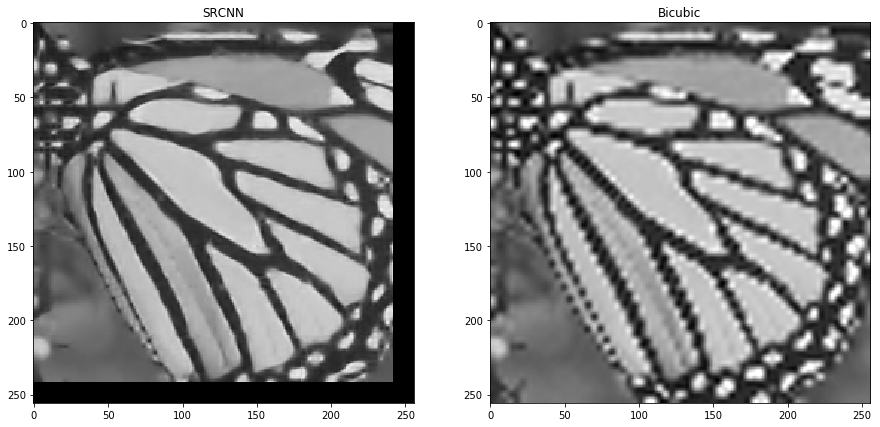

In [50]:
plot_images([bicubic, image], ["Bicubic", "SRCNN"], size=(15, 10))

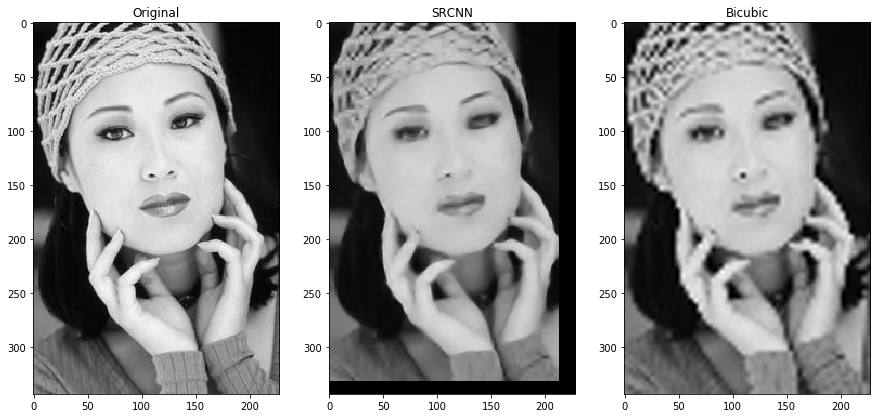

In [51]:
id = 0
val_img = vald_pil[id]

org, bic = get_input_images(val_img, 4.)
subBic, subOrg = generate_patches(val_img, 
                                  patch_size = 32, 
                                  label_size = 32, 
                                  scale = 4., 
                                  stride = 30 )
    
    
subBic = np.asarray(subBic)
subOrg = np.asarray(subOrg)

subOrg, subBic = normalize(subOrg, subBic)
subOrg, subBic = reshape(subOrg, subBic, ch=1)

pred = model.predict(subBic)
pred = pred.clip(0,1)

h, w = utility.getSize(val_img)
image = patch_to_image(pred, h, w, 0, 32, 32, stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))

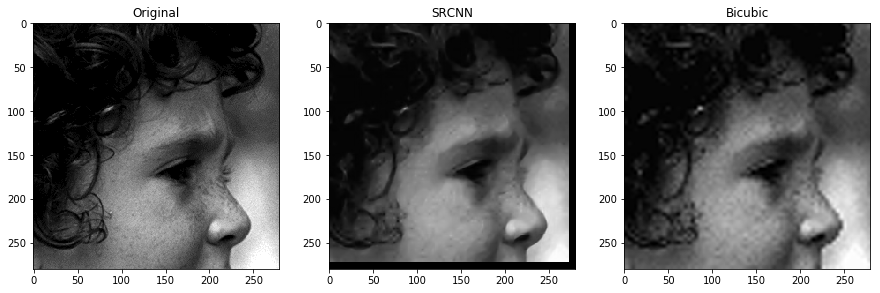

In [54]:
id = 2
val_img = vald_pil[id]

org, bic = get_input_images(val_img, 4.)
subBic, subOrg = generate_patches(val_img, 
                                  patch_size = 32, 
                                  label_size = 32, 
                                  scale = 4., 
                                  stride = 30 )
    
    
subBic = np.asarray(subBic)
subOrg = np.asarray(subOrg)

subOrg, subBic = normalize(subOrg, subBic)
subOrg, subBic = reshape(subOrg, subBic, ch=1)

pred = model.predict(subBic, 64)
pred = pred.clip(0,1)

h, w = utility.getSize(val_img)
image = patch_to_image(pred, h, w, 0, 32, 32, stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))

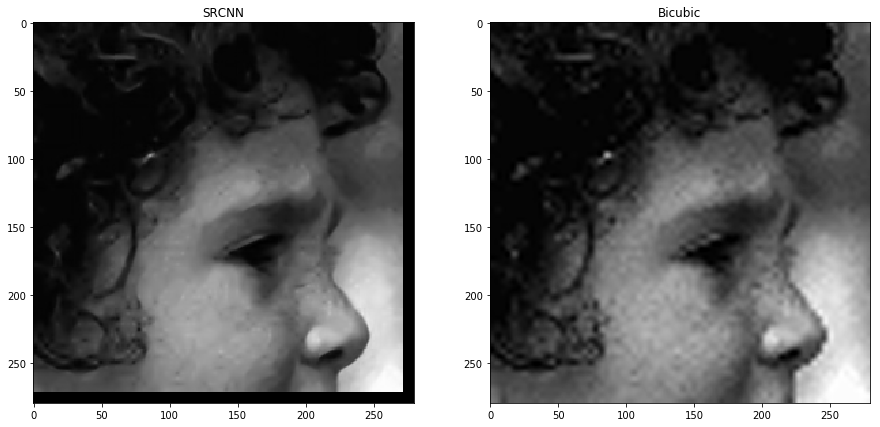

In [55]:
plot_images([bic, image], ["Bicubic", "SRCNN"], size=(15, 10))

# Load model

In [46]:
name = "sptial_deep_model_50_ycbcr"
model = load_model(name)

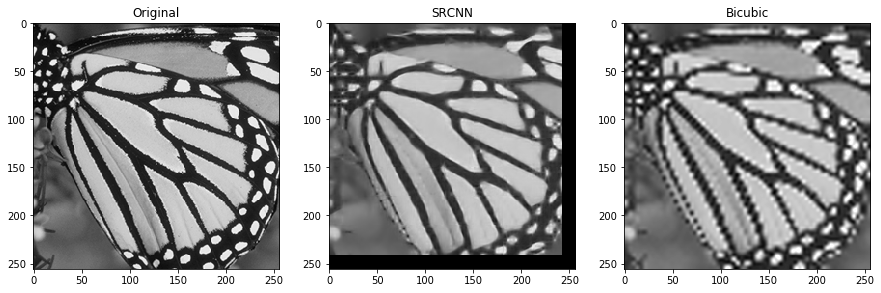

In [36]:
id = 3

vald_pil = get_test_dataset()
img = vald_pil[id]

org, bic = get_input_images(img, scale=4.)
image = predict_image(model, img, scale=4., stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))